In [1]:
import torch
import torch.nn as nn
import torchvision as tv
import torch.nn.functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader,Dataset
from torchvision.datasets import Caltech256,VOCDetection
from torchvision.models import vgg16,alexnet,resnet50
from tqdm import tqdm

In [2]:
!wget http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
!tar -xf /content/VOCtrainval_11-May-2012.tar

--2021-11-29 09:45:43--  http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar [following]
--2021-11-29 09:45:43--  https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/octet-stream]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  57.9MB/s    in 34s     

2021-11-29 09:46:18 (55.9 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [3]:
import os
unique_labels = [i[:-10] for i in os.listdir('/content/VOCdevkit/VOC2012/ImageSets/Main') if i.endswith('_train.txt')]
class2lab = {i:v for i,v in enumerate(unique_labels)}
lab2class = {v:i for i,v in class2lab.items()}

In [4]:
#pascal[0][1]['annotation']['object'][0]['name']


class DS(Dataset):
  def __init__(self,pascal,is_train=True):
    self.pascal = pascal
    self.is_train= is_train
    mean=[0.457342265910642, 0.4387686270106377, 0.4073427106250871]
    std=[0.26753769276329037, 0.2638145880487105, 0.2776826934044154]

    self.transforms_train =  T.Compose([T.Resize((224, 224)),
#                                      T.RandomChoice([
#                                              T.CenterCrop(300),
#                                              T.RandomResizedCrop(300, scale=(0.80, 1.0)),
#                                              ]),                                      
                                      T.RandomChoice([
                                          T.ColorJitter(brightness=(0.80, 1.20)),
                                          T.RandomGrayscale(p = 0.25)
                                          ]),
                                      T.RandomHorizontalFlip(p = 0.25),
                                      T.RandomRotation(25),
                                      T.ToTensor(), 
                                      T.Normalize(mean = mean, std = std),
                                      ])
    self.transforms_valid = T.Compose([T.Resize(330), 
                                          T.CenterCrop(300), 
                                          T.ToTensor(), 
                                          T.Normalize(mean = mean, std = std),
                                          ])
    
    self.transforms = self.transforms_train if self.is_train else self.transforms_valid

  def __getitem__(self,idx):
    img,label = self.pascal[idx]
    return self.transforms(img),lab2class[label['annotation']['object'][0]['name']]

  def __len__(self):
    return len(self.pascal)


train_ds = DS(VOCDetection('nowhere',year = '2012',image_set ='train',download=True))
# valid_ds = DS(VOCDetection('nowhere',year = '2012',image_set ='trainval',download=True),False)
test_ds = DS(VOCDetection('nowhere',year = '2012',image_set ='val',download=True),False)

  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting nowhere/VOCtrainval_11-May-2012.tar to nowhere
Using downloaded and verified file: nowhere/VOCtrainval_11-May-2012.tar
Extracting nowhere/VOCtrainval_11-May-2012.tar to nowhere


In [5]:
batch_size =32
train_loader = DataLoader(train_ds,batch_size,shuffle=True)
# valid_loader = DataLoader(valid_ds,batch_size,shuffle=False)
test_loader = DataLoader(test_ds,batch_size,shuffle=False)

In [6]:
def train_one_step(model,inputs,labels,loss_fn,optimizer,device):
    model.train()
    optimizer.zero_grad()
    inputs,labels = inputs.to(device),labels.to(device)
    y_pred = model(inputs)
    loss = loss_fn(y_pred,labels)
    loss.backward()
    optimizer.step()
    return loss.item()

def validate_one_step(model,inputs,labels,loss_fn,device):
    model.eval()
    with torch.no_grad():
        inputs,labels = inputs.to(device),labels.to(device)
        y_pred = model(inputs)
        loss = loss_fn(y_pred,labels)
        return loss.item()

In [7]:
def validate(model,validation_loader,loss_fn,device):
    val_loss =0
    for batch in validation_loader:
        inputs,labels = batch
        val_loss+=validate_one_step(model,inputs,labels,loss_fn,device)
    val_loss = val_loss/len(validation_loader)
    return val_loss

def train(model,num_epochs,train_loader,validation_loader=None,loss_fn=None,optimizer=None,device=None,path=''):
    loss_history=[]
    val_loss_history =[]
    for epoch in range(1,num_epochs+1):
        loss = 0
        for batch in tqdm(train_loader,desc = f'Epoch {epoch}'):
            inputs,labels = batch
            loss+=train_one_step(model,inputs,labels,loss_fn,optimizer,device)
        loss = loss/len(train_loader)
        loss_history.append(loss)
        
        if validation_loader is not None:
            val_loss = validate(model,validation_loader,loss_fn,device)
            print(f'At the end of epoch {epoch} Training Loss is {loss}. Validation loss is {val_loss}')
            val_loss_history.append(val_loss)
        else:
            print(f'At the end of epoch {epoch} Training Loss is {loss}')
        if epoch%5==0:
            save_cnn(model,path+'/model_state/'+str(epoch)+'.pth')
            model.to(device)
    if validation_loader is None:
        return loss_history
    return loss_history,val_loss_history
        

In [8]:
import numpy as np
def get_preds(model,validation_loader,device):
    true_labels =[]
    pred_labels =[]
    model.eval()

    with torch.no_grad():
      for batch in tqdm(validation_loader):
          inputs,labels = batch
          inputs = inputs.to(device)
          y_pred = model(inputs).detach().cpu().numpy()
          pred_labels.extend(np.argmax(y_pred,axis=1).tolist())
          true_labels.extend(labels.tolist())

    return np.array(true_labels),np.array(pred_labels) 

from sklearn.metrics import classification_report

# VGG

In [9]:
vgg = vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [10]:
for i in vgg.features:
  i.requires_grad = False
for i in vgg.classifier[:-1]:
  i.requires_grad = False
vgg.classifier[-1] = nn.Linear(4096, len(class2lab))

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.optim import Adam
optimizer = Adam(filter(lambda p: p.requires_grad, vgg.parameters()),lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
print('Using ',device)
vgg.to(device)
!mkdir vgg
!mkdir vgg/model_state

Using  cuda


In [12]:
def save_cnn(model,path):
    model.to(torch.device('cpu'))
    torch.save(model.state_dict(), path)

In [13]:
from tqdm import tqdm
l,vl = train(vgg,10,train_loader,test_loader,loss_fn,optimizer,device,'/content/vgg')

Epoch 1: 100%|██████████| 179/179 [04:10<00:00,  1.40s/it]


At the end of epoch 1 Training Loss is 1.6287146770088365. Validation loss is 1.2983472910556164


Epoch 2: 100%|██████████| 179/179 [04:06<00:00,  1.38s/it]


At the end of epoch 2 Training Loss is 1.1060727145418774. Validation loss is 1.1164562646504288


Epoch 3: 100%|██████████| 179/179 [04:06<00:00,  1.38s/it]


At the end of epoch 3 Training Loss is 0.8839371747144774. Validation loss is 1.154131157385124


Epoch 4: 100%|██████████| 179/179 [04:06<00:00,  1.38s/it]


At the end of epoch 4 Training Loss is 0.768342396483741. Validation loss is 1.0068823071299018


Epoch 5: 100%|██████████| 179/179 [04:04<00:00,  1.37s/it]


At the end of epoch 5 Training Loss is 0.6579579341344993. Validation loss is 1.0714488805650355


Epoch 6: 100%|██████████| 179/179 [04:04<00:00,  1.37s/it]


At the end of epoch 6 Training Loss is 0.5566337134418541. Validation loss is 1.1573675114374895


Epoch 7: 100%|██████████| 179/179 [04:04<00:00,  1.37s/it]


At the end of epoch 7 Training Loss is 0.4622227253194628. Validation loss is 1.1534134157738842


Epoch 8: 100%|██████████| 179/179 [04:03<00:00,  1.36s/it]


At the end of epoch 8 Training Loss is 0.4060914685856031. Validation loss is 1.2937746899468558


Epoch 9: 100%|██████████| 179/179 [04:04<00:00,  1.37s/it]


At the end of epoch 9 Training Loss is 0.3508710890758637. Validation loss is 1.4123887516312548


Epoch 10: 100%|██████████| 179/179 [04:03<00:00,  1.36s/it]


At the end of epoch 10 Training Loss is 0.31358523179865416. Validation loss is 1.42562169950087


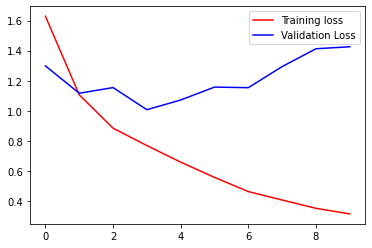

In [14]:
import matplotlib.pyplot as plt
plt.plot(l,'r-',label='Training loss')
plt.plot(vl,'b-',label ='Validation Loss')
plt.legend()
plt.show()

In [15]:
train_true,train_pred =  get_preds(vgg,train_loader,device)

print('Training Report')
print(classification_report(train_true,train_pred))

test_true,test_pred = get_preds(vgg,test_loader,device)
print('Testing Report')
print(classification_report(test_true,test_pred))

100%|██████████| 179/179 [01:38<00:00,  1.81it/s]


Training Report
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       129
           1       0.92      0.96      0.94       148
           2       0.95      0.96      0.96       216
           3       0.82      0.95      0.88       202
           4       0.93      0.86      0.89       262
           5       0.96      0.96      0.96       377
           6       1.00      0.90      0.95       579
           7       0.98      0.87      0.92       136
           8       0.97      0.96      0.96       189
           9       0.94      0.88      0.91       173
          10       1.00      0.82      0.90       221
          11       0.93      0.97      0.95       211
          12       0.93      1.00      0.96       249
          13       0.89      0.95      0.92       872
          14       0.97      0.89      0.93       368
          15       0.79      0.99      0.88       163
          16       0.99      0.96      0.97       495
          1

100%|██████████| 182/182 [03:30<00:00,  1.16s/it]

Testing Report
              precision    recall  f1-score   support

           0       0.32      0.22      0.26       128
           1       0.66      0.53      0.59       150
           2       0.72      0.70      0.71       210
           3       0.35      0.43      0.38       167
           4       0.43      0.36      0.39       265
           5       0.76      0.89      0.82       354
           6       0.91      0.57      0.70       591
           7       0.61      0.38      0.47       124
           8       0.83      0.81      0.82       186
           9       0.57      0.47      0.52       196
          10       0.86      0.45      0.59       215
          11       0.76      0.78      0.77       192
          12       0.63      0.89      0.74       246
          13       0.55      0.76      0.64       979
          14       0.75      0.54      0.63       391
          15       0.47      0.81      0.59       150
          16       0.83      0.78      0.80       512
          17

# AlexNet

In [16]:
an = alexnet(pretrained=True)
for i in an.features:
  i.requires_grad = False
for i in an.classifier[:-1]:
  i.requires_grad = False
an.classifier[-1] = nn.Linear(4096, len(class2lab))

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [17]:
optimizer = Adam(filter(lambda p: p.requires_grad, an.parameters()),lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
print('Using ',device)
an.to(device)
!mkdir an
!mkdir an/model_state

Using  cuda


In [18]:
l,vl = train(an,10,train_loader,test_loader,loss_fn,optimizer,device,'/content/an')

Epoch 1: 100%|██████████| 179/179 [01:08<00:00,  2.62it/s]


At the end of epoch 1 Training Loss is 1.762964610946911. Validation loss is 1.323081007370582


Epoch 2: 100%|██████████| 179/179 [01:08<00:00,  2.63it/s]


At the end of epoch 2 Training Loss is 1.3067066276539638. Validation loss is 1.2974078838641827


Epoch 3: 100%|██████████| 179/179 [01:08<00:00,  2.63it/s]


At the end of epoch 3 Training Loss is 1.1337214102292195. Validation loss is 1.2523201229153098


Epoch 4: 100%|██████████| 179/179 [01:07<00:00,  2.64it/s]


At the end of epoch 4 Training Loss is 1.0129207855496327. Validation loss is 1.2449274066385332


Epoch 5: 100%|██████████| 179/179 [01:07<00:00,  2.66it/s]


At the end of epoch 5 Training Loss is 0.8798662652183511. Validation loss is 1.3821510194422124


Epoch 6: 100%|██████████| 179/179 [01:07<00:00,  2.65it/s]


At the end of epoch 6 Training Loss is 0.7767259327060018. Validation loss is 1.3471985930924888


Epoch 7: 100%|██████████| 179/179 [01:07<00:00,  2.66it/s]


At the end of epoch 7 Training Loss is 0.6898596135264669. Validation loss is 1.3361836226431878


Epoch 8: 100%|██████████| 179/179 [01:08<00:00,  2.62it/s]


At the end of epoch 8 Training Loss is 0.6042637745095365. Validation loss is 1.345932778093841


Epoch 9: 100%|██████████| 179/179 [01:08<00:00,  2.62it/s]


At the end of epoch 9 Training Loss is 0.5403955538845595. Validation loss is 1.4633477484131907


Epoch 10: 100%|██████████| 179/179 [01:10<00:00,  2.53it/s]


At the end of epoch 10 Training Loss is 0.44913184234882864. Validation loss is 1.5197265667247248


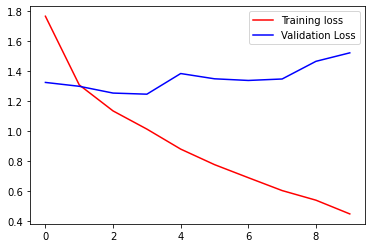

In [19]:
import matplotlib.pyplot as plt
plt.plot(l,'r-',label='Training loss')
plt.plot(vl,'b-',label ='Validation Loss')
plt.legend()
plt.show()

In [20]:
train_true,train_pred = get_preds(an,train_loader,device)

print('Training Report')
print(classification_report(train_true,train_pred))

test_true,test_pred = get_preds(an,test_loader,device)
print('Testing Report')
print(classification_report(test_true,test_pred))

100%|██████████| 179/179 [00:58<00:00,  3.08it/s]


Training Report
              precision    recall  f1-score   support

           0       0.80      0.91      0.86       129
           1       0.94      0.89      0.92       148
           2       0.99      0.89      0.94       216
           3       0.84      0.92      0.88       202
           4       0.88      0.87      0.88       262
           5       0.98      0.96      0.97       377
           6       0.98      0.93      0.96       579
           7       0.92      0.88      0.89       136
           8       0.87      0.97      0.92       189
           9       0.96      0.78      0.86       173
          10       0.97      0.92      0.94       221
          11       0.97      0.92      0.94       211
          12       0.96      0.95      0.95       249
          13       0.86      0.96      0.90       872
          14       0.93      0.90      0.92       368
          15       0.95      0.94      0.95       163
          16       0.97      0.97      0.97       495
          1

100%|██████████| 182/182 [01:08<00:00,  2.66it/s]

Testing Report
              precision    recall  f1-score   support

           0       0.27      0.24      0.26       128
           1       0.59      0.31      0.41       150
           2       0.65      0.49      0.56       210
           3       0.32      0.41      0.36       167
           4       0.41      0.35      0.37       265
           5       0.66      0.76      0.71       354
           6       0.80      0.53      0.64       591
           7       0.39      0.46      0.42       124
           8       0.69      0.78      0.73       186
           9       0.69      0.32      0.44       196
          10       0.77      0.51      0.61       215
          11       0.68      0.42      0.52       192
          12       0.79      0.64      0.71       246
          13       0.52      0.73      0.61       979
          14       0.53      0.49      0.51       391
          15       0.75      0.57      0.65       150
          16       0.62      0.85      0.72       512
          17

# ResNet

In [27]:
rn = resnet50(pretrained=True)
for i in rn.parameters():
  i.requires_grad=False
rn.fc = nn.Linear(in_features=rn.fc.in_features, out_features=len(class2lab))

In [28]:
optimizer = Adam(filter(lambda p: p.requires_grad, rn.parameters()),lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
print('Using ',device)
rn.to(device)
!mkdir rn
!mkdir rn/model_state

Using  cuda
mkdir: cannot create directory ‘rn’: File exists
mkdir: cannot create directory ‘rn/model_state’: File exists


In [ ]:
l,vl = train(rn,50,train_loader,test_loader,loss_fn,optimizer,device,'/content/rn')

Epoch 1: 100%|██████████| 179/179 [01:31<00:00,  1.95it/s]


At the end of epoch 1 Training Loss is 2.4370659956052982. Validation loss is 2.155931458368406


Epoch 2: 100%|██████████| 179/179 [01:26<00:00,  2.07it/s]


At the end of epoch 2 Training Loss is 1.8393634797474525. Validation loss is 1.732920221575014


Epoch 3: 100%|██████████| 179/179 [01:27<00:00,  2.05it/s]


At the end of epoch 3 Training Loss is 1.5185146398384477. Validation loss is 1.4773540018679021


Epoch 4: 100%|██████████| 179/179 [01:27<00:00,  2.04it/s]


At the end of epoch 4 Training Loss is 1.3450454130519036. Validation loss is 1.3244005549740006


Epoch 5: 100%|██████████| 179/179 [01:25<00:00,  2.08it/s]


At the end of epoch 5 Training Loss is 1.2263547528389447. Validation loss is 1.2312133682298136


Epoch 6: 100%|██████████| 179/179 [01:27<00:00,  2.04it/s]


At the end of epoch 6 Training Loss is 1.1547651856971186. Validation loss is 1.1594520217769748


Epoch 7: 100%|██████████| 179/179 [01:27<00:00,  2.04it/s]


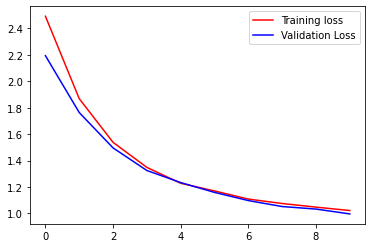

In [24]:
import matplotlib.pyplot as plt
plt.plot(l,'r-',label='Training loss')
plt.plot(vl,'b-',label ='Validation Loss')
plt.legend()
plt.show()

In [25]:
train_true,train_pred = get_preds(rn,train_loader,device)

print('Training Report')
print(classification_report(train_true,train_pred))

test_true,test_pred = get_preds(rn,test_loader,device)
print('Testing Report')
print(classification_report(test_true,test_pred))

100%|██████████| 179/179 [01:26<00:00,  2.08it/s]


Training Report
              precision    recall  f1-score   support

           0       0.54      0.34      0.42       129
           1       0.77      0.58      0.66       148
           2       0.83      0.69      0.75       216
           3       0.48      0.39      0.43       202
           4       0.51      0.37      0.43       262
           5       0.79      0.88      0.83       377
           6       0.85      0.85      0.85       579
           7       0.75      0.43      0.54       136
           8       0.85      0.77      0.81       189
           9       0.59      0.43      0.50       173
          10       0.69      0.83      0.75       221
          11       0.79      0.71      0.75       211
          12       0.83      0.81      0.82       249
          13       0.53      0.73      0.62       872
          14       0.69      0.74      0.72       368
          15       0.82      0.74      0.78       163
          16       0.89      0.88      0.89       495
          1

100%|██████████| 182/182 [02:13<00:00,  1.36it/s]

Testing Report
              precision    recall  f1-score   support

           0       0.44      0.22      0.29       128
           1       0.82      0.69      0.75       150
           2       0.78      0.60      0.68       210
           3       0.56      0.59      0.57       167
           4       0.56      0.40      0.46       265
           5       0.82      0.93      0.87       354
           6       0.84      0.86      0.85       591
           7       0.67      0.52      0.58       124
           8       0.92      0.87      0.89       186
           9       0.77      0.55      0.64       196
          10       0.78      0.80      0.79       215
          11       0.79      0.78      0.78       192
          12       0.90      0.82      0.86       246
          13       0.56      0.82      0.66       979
          14       0.85      0.73      0.78       391
          15       0.87      0.77      0.82       150
          16       0.94      0.91      0.93       512
          17